In [82]:
import pandas as pd
df = pd.read_csv("data_1.csv", encoding='latin-1')
df.head()

earthquake_id                                     title  magnitude   depth  \
0              1          M 6.5 - 42 km W of Sola, Vanuatu        6.5  192.96   
1              2  M 6.5 - 43 km S of Intipucá, El Salvador        6.5   69.73   
2              3  M 6.6 - 25 km ESE of Loncopué, Argentina        6.6  171.37   
3              4     M 7.2 - 98 km S of Sand Point, Alaska        7.2   32.57   
4              5                  M 7.3 - Alaska Peninsula        7.3   21.00   

   latitude  longitude  Year        date_time  cdi  mmi  tsunami  sig  \
0  -13.8814   167.1580  2023  8/16/2023 12:47    7    4        0  657   
1   12.8140   -88.1265  2023   7/19/2023 0:22    8    6        0  775   
2  -38.1911   -70.3731  2023   7/17/2023 3:05    7    5        0  899   
3   54.3844  -160.6990  2023   7/16/2023 6:48    6    6        1  860   
4   54.4900  -160.7960  2023   7/16/2023 6:48    0    5        1  820   

       dmin    gap  nst magType  
0  7.177000   25.0  114     mww  
1  0.679000   40.0   92     mww  
2  1.634000   28.0   70     mww  
3  0.907000   36.0  173     mww  
4  0.879451  172.8   79      Mi

In [83]:
df['magType'].unique()

array(['mww', 'Mi', 'mwc', 'mwb', 'ml', 'mw', 'ms', 'mb', 'md'],
      dtype=object)

In [84]:
# Define conversion functions
def convert_to_mw(magnitude, mag_type):
    if mag_type == 'mw' or mag_type in ['mww', 'mwb', 'mwc']:
        return magnitude
    elif mag_type == 'ml':
        return 0.67 * magnitude + 1.46
    elif mag_type == 'ms':
        return 0.67 * magnitude + 2.07
    elif mag_type == 'mb':
        return 1.27 * magnitude - 0.18
    elif mag_type == 'md':
        return 0.8 * magnitude + 1.2
    elif mag_type == 'Mi':
        # Assuming a generic adjustment factor for Mi
        return magnitude + 1.0  # Adjust based on region-specific data
    else:
        return None  # Unknown magType

# Apply conversion
df['mw'] = df.apply(lambda row: convert_to_mw(row['magnitude'], row['magType']), axis=1)

In [85]:
df_1 = df.copy

# Applying clustering based on Density using DBSCAN

In [86]:
latitude = df['latitude']
longitude = df['longitude']
coordinates = df[['latitude', 'longitude']]

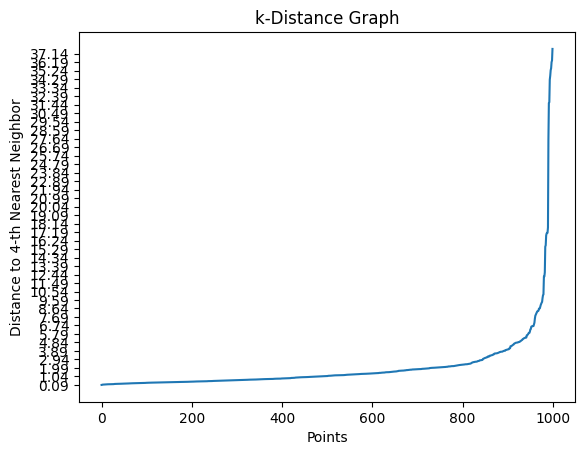

In [87]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

k = 4  # min_samples
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(coordinates)
distances, indices = neighbors_fit.kneighbors(coordinates)

# Sort the distances in increasing order and plot the graph
distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Distance to {}-th Nearest Neighbor'.format(k))
plt.title('k-Distance Graph')

# Adjust y-axis ticks for granularity
plt.yticks(np.arange(min(distances), max(distances), 0.95))



plt.show()

In [88]:
data = df.copy()

In [89]:
from sklearn.cluster import KMeans
import pandas as pd
from geopy.distance import great_circle
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

coordinates = data[['latitude', 'longitude']].to_numpy()

# Using DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=4, metric='haversine')  # 'haversine' for spherical distances
clusters = dbscan.fit_predict(np.radians(coordinates))
data['cluster'] = clusters
print(data['cluster'].value_counts())

cluster
 0     648
 1     187
 3      30
 2      27
-1      23
 6      16
 4      15
 5      12
 11     11
 7       8
 8       7
 9       7
 12      5
 10      4
Name: count, dtype: int64


In [90]:
import folium
from folium.plugins import MarkerCluster

center_lat = data['latitude'].mean()
center_lon = data['longitude'].mean()

# Initializing the map
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Creating a color map for the clusters
import matplotlib.cm as cm
import matplotlib.colors as colors

n_clusters = data['cluster'].nunique()
colormap = cm.get_cmap('tab10', n_clusters)  # Choosing a colormap
cluster_colors = {cluster: colors.rgb2hex(colormap(cluster)) for cluster in data['cluster'].unique()}

# Adding markers to the map
for _, row in data.iterrows():
    cluster = row['cluster']
    if cluster == -1:  # Handling noise points separately (gray color)
        color = '#808080'
    else:
        color = cluster_colors[cluster]

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Cluster: {cluster}"
    ).add_to(m)

m

<ipython-input-90-7d8178d99d58>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', n_clusters)  # Choosing a colormap


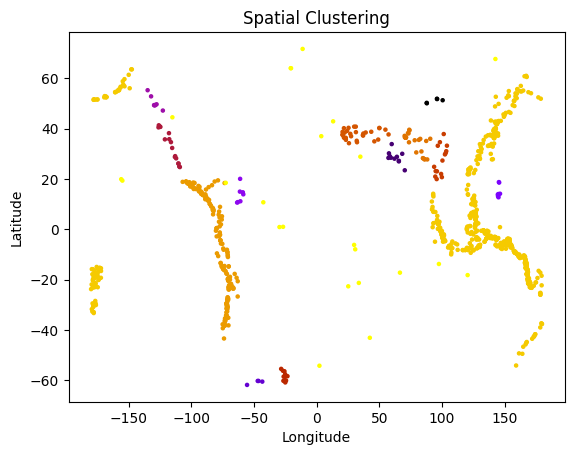

In [91]:
import matplotlib.pyplot as plt
plt.scatter(data['longitude'], data['latitude'], c=data['cluster'],cmap='gnuplot_r', s=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Clustering')
plt.show()

In [92]:
outliers = data[data['cluster']== -1 ]
outliers.head()

earthquake_id                                 title  magnitude  depth  \
102            103    M 6.7 - Mauritius - Reunion region        6.7  10.00   
120            121    M 6.9 - central Mid-Atlantic Ridge        6.9  10.00   
123            124    M 6.5 - central Mid-Atlantic Ridge        6.5  10.00   
139            140                M 6.5 - Stanley, Idaho        6.5  12.06   
158            159  M 6.6 - 200km W of Broome, Australia        6.6  10.00   

     latitude  longitude  Year        date_time  cdi  mmi  tsunami   sig  \
102  -17.2495    66.3745  2021  5/12/2021 14:05    9    3        0   694   
120    0.9604   -26.8332  2020  9/18/2020 21:43    0    3        1   732   
123    0.8696   -29.7046  2020  8/30/2020 21:20    4    5        0   651   
139   44.4646  -115.1180  2020  3/31/2020 23:52    8    8        0  1410   
158  -18.2242   120.3580  2019   7/14/2019 5:39    5    5        0   791   

       dmin   gap  nst magType   mw  cluster  
102  10.669  45.0    0     mww  6.7       -1  
120  11.255  16.0    0     mww  6.9       -1  
123  15.394  31.0    0     mww  6.5       -1  
139   0.885  31.0    0     mww  6.5       -1  
158   2.978  32.0    0     mww  6.6       -1

In [93]:
data.drop(outliers.index, inplace=True)
df = data.copy()
df.head()

earthquake_id                                     title  magnitude   depth  \
0              1          M 6.5 - 42 km W of Sola, Vanuatu        6.5  192.96   
1              2  M 6.5 - 43 km S of Intipucá, El Salvador        6.5   69.73   
2              3  M 6.6 - 25 km ESE of Loncopué, Argentina        6.6  171.37   
3              4     M 7.2 - 98 km S of Sand Point, Alaska        7.2   32.57   
4              5                  M 7.3 - Alaska Peninsula        7.3   21.00   

   latitude  longitude  Year        date_time  cdi  mmi  tsunami  sig  \
0  -13.8814   167.1580  2023  8/16/2023 12:47    7    4        0  657   
1   12.8140   -88.1265  2023   7/19/2023 0:22    8    6        0  775   
2  -38.1911   -70.3731  2023   7/17/2023 3:05    7    5        0  899   
3   54.3844  -160.6990  2023   7/16/2023 6:48    6    6        1  860   
4   54.4900  -160.7960  2023   7/16/2023 6:48    0    5        1  820   

       dmin    gap  nst magType   mw  cluster  
0  7.177000   25.0  114     mww  6.5        0  
1  0.679000   40.0   92     mww  6.5        1  
2  1.634000   28.0   70     mww  6.6        1  
3  0.907000   36.0  173     mww  7.2        0  
4  0.879451  172.8   79      Mi  8.3        0

# EDA

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 977 entries, 0 to 999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   earthquake_id  977 non-null    int64  
 1   title          977 non-null    object 
 2   magnitude      977 non-null    float64
 3   depth          977 non-null    float64
 4   latitude       977 non-null    float64
 5   longitude      977 non-null    float64
 6   Year           977 non-null    int64  
 7   date_time      977 non-null    object 
 8   cdi            977 non-null    int64  
 9   mmi            977 non-null    int64  
 10  tsunami        977 non-null    int64  
 11  sig            977 non-null    int64  
 12  dmin           977 non-null    float64
 13  gap            977 non-null    float64
 14  nst            977 non-null    int64  
 15  magType        977 non-null    object 
 16  mw             977 non-null    float64
 17  cluster        977 non-null    int64  
dtypes: float64(7), 

In [95]:
df.describe()

earthquake_id   magnitude       depth    latitude   longitude  \
count     977.000000  977.000000  977.000000  977.000000  977.000000   
mean      501.566018    6.944729   76.035322    4.124749   52.707062   
std       288.632917    0.439816  132.005592   26.372357  118.032626   
min         1.000000    6.500000    2.700000  -61.848400 -179.968000   
25%       255.000000    6.600000   16.100000  -13.481000  -71.799000   
50%       502.000000    6.800000   30.000000   -2.520000  118.631000   
75%       750.000000    7.100000   56.000000   24.696000  149.487000   
max      1000.000000    9.100000  670.810000   63.514400  179.662000   

              Year         cdi         mmi     tsunami          sig  \
count   977.000000  977.000000  977.000000  977.000000   977.000000   
mean   2009.931423    3.607984    6.011259    0.326510   845.010235   
std       8.244124    3.323238    1.410905    0.469176   294.777090   
min    1995.000000    0.000000    1.000000    0.000000   650.000000   
25%    2003.000000    0.000000    5.000000    0.000000   691.000000   
50%    2011.000000    4.000000    6.000000    0.000000   745.000000   
75%    2017.000000    7.000000    7.000000    1.000000   873.000000   
max    2023.000000    9.000000   10.000000    1.000000  2910.000000   

             dmin         gap         nst          mw    cluster  
count  977.000000  977.000000  977.000000  977.000000  977.00000  
mean     1.072994   20.697738  193.879222    6.955147    0.96520  
std      1.896978   23.649034  239.144462    0.451013    2.17776  
min      0.000000    0.000000    0.000000    5.815000    0.00000  
25%      0.000000    0.000000    0.000000    6.600000    0.00000  
50%      0.000000   18.000000    0.000000    6.800000    0.00000  
75%      1.529000   27.000000  402.000000    7.200000    1.00000  
max     12.896000  239.000000  934.000000    9.100000   12.00000

In [96]:
df.head()

earthquake_id                                     title  magnitude   depth  \
0              1          M 6.5 - 42 km W of Sola, Vanuatu        6.5  192.96   
1              2  M 6.5 - 43 km S of Intipucá, El Salvador        6.5   69.73   
2              3  M 6.6 - 25 km ESE of Loncopué, Argentina        6.6  171.37   
3              4     M 7.2 - 98 km S of Sand Point, Alaska        7.2   32.57   
4              5                  M 7.3 - Alaska Peninsula        7.3   21.00   

   latitude  longitude  Year        date_time  cdi  mmi  tsunami  sig  \
0  -13.8814   167.1580  2023  8/16/2023 12:47    7    4        0  657   
1   12.8140   -88.1265  2023   7/19/2023 0:22    8    6        0  775   
2  -38.1911   -70.3731  2023   7/17/2023 3:05    7    5        0  899   
3   54.3844  -160.6990  2023   7/16/2023 6:48    6    6        1  860   
4   54.4900  -160.7960  2023   7/16/2023 6:48    0    5        1  820   

       dmin    gap  nst magType   mw  cluster  
0  7.177000   25.0  114     mww  6.5        0  
1  0.679000   40.0   92     mww  6.5        1  
2  1.634000   28.0   70     mww  6.6        1  
3  0.907000   36.0  173     mww  7.2        0  
4  0.879451  172.8   79      Mi  8.3        0

## Univariate Analysis

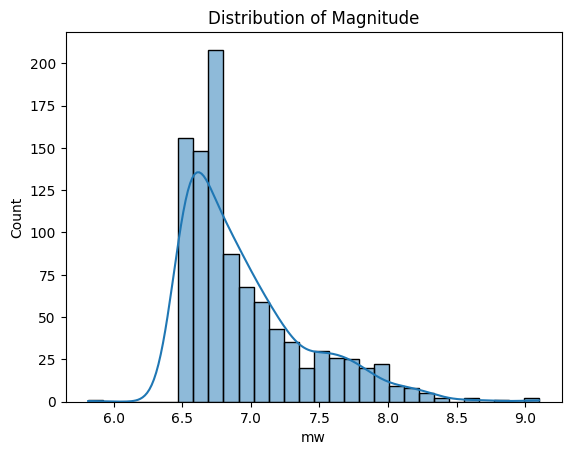

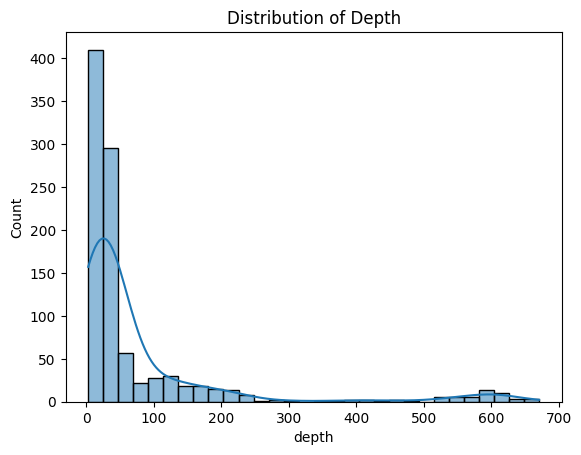

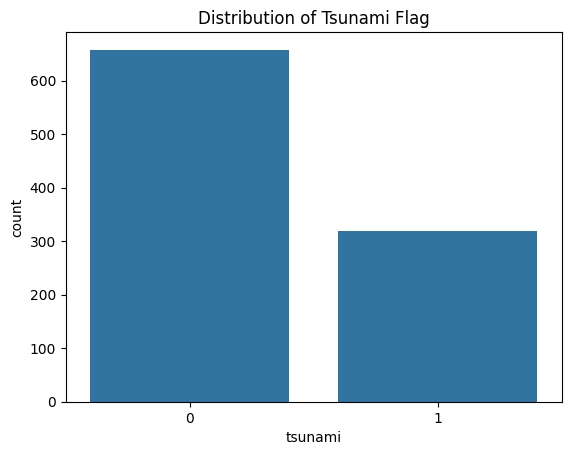

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Magnitude
sns.histplot(df['mw'], kde=True, bins=30)
plt.title('Distribution of Magnitude')
plt.show()

# Distribution of Depth
sns.histplot(df['depth'], kde=True, bins=30)
plt.title('Distribution of Depth')
plt.show()

# Distribution of Tsunami Flag
sns.countplot(x='tsunami', data=df)
plt.title('Distribution of Tsunami Flag')
plt.show()

## Bivariate Aanlysis

In [98]:
df_c = data.copy()
df_c.drop(['title', 'magnitude','date_time','magType','earthquake_id','latitude','longitude'], axis=1, inplace=True)

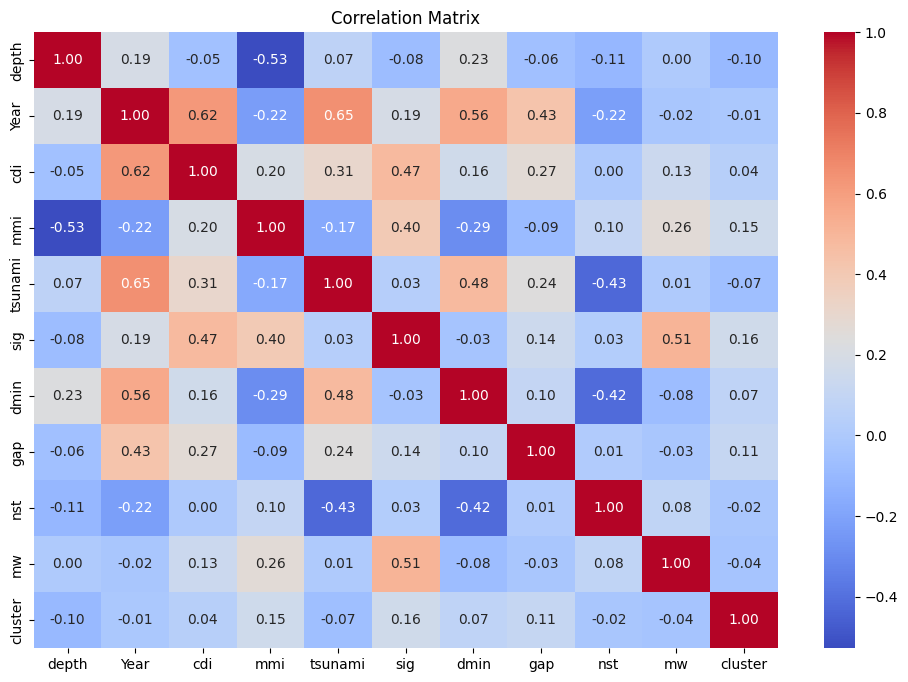

In [99]:
# Compute correlation matrix
correlation_matrix = df_c.corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

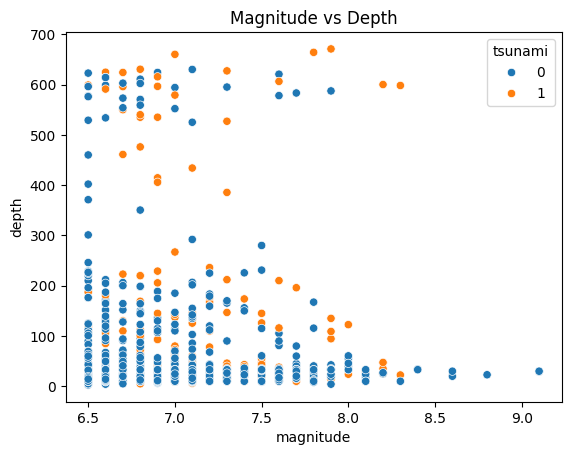

In [100]:
# Magnitude vs Depth
sns.scatterplot(x='magnitude', y='depth', hue='tsunami', data=df)
plt.title('Magnitude vs Depth')
plt.show()

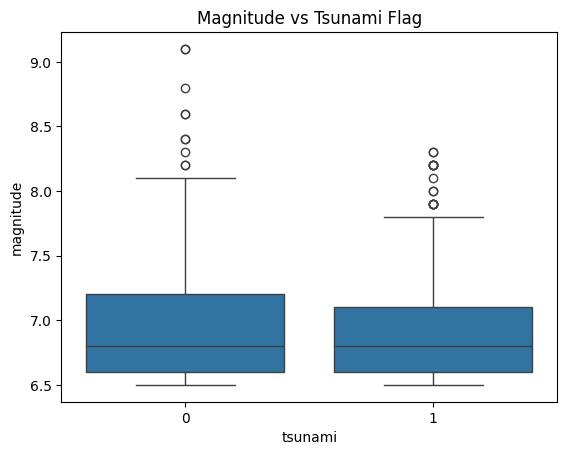

In [101]:
# Boxplot of Magnitude for Tsunami Flag
sns.boxplot(x='tsunami', y='magnitude', data=df)
plt.title('Magnitude vs Tsunami Flag')
plt.show()

## Correlation

In [102]:
from scipy.stats import spearmanr

# Compute correlation for numeric features
numeric_features = ['magnitude', 'depth', 'mmi', 'sig', 'dmin']
correlations = {}

for feature in numeric_features:
    corr, _ = spearmanr(df[feature], df['tsunami'])
    correlations[feature] = corr

# Display correlations
print("Spearman Correlations with Tsunami Flag:")
for key, value in correlations.items():
    print(f"{key}: {value:.3f}")

Spearman Correlations with Tsunami Flag:
magnitude: 0.016
depth: 0.007
mmi: -0.170
sig: 0.055
dmin: 0.672


In [103]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2

# Encode categorical data
le = LabelEncoder()
df['magnitude_type_encoded'] = le.fit_transform(df['magType'])

# Chi-Square Test
chi2_features, p_values = chi2(df[['magnitude_type_encoded']], df['tsunami'])

# Display results
print(f"Chi-Square Scores: {chi2_features}")
print(f"P-Values: {p_values}")


Chi-Square Scores: [23.54782086]
P-Values: [1.21847347e-06]


In [104]:
df_xyz= df.copy()
df_xyz.drop(['title', 'date_time','Year','latitude','longitude','earthquake_id'], axis=1, inplace=True)

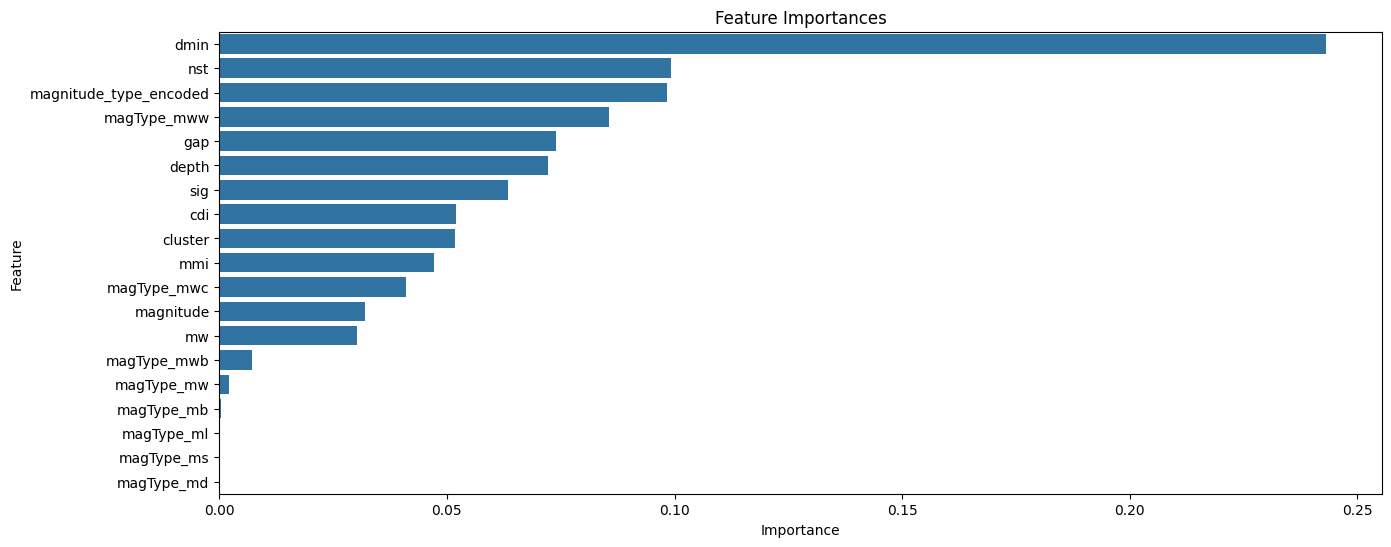

In [105]:
from sklearn.ensemble import RandomForestClassifier

# Prepare data
X = df_xyz.drop(['tsunami'], axis=1)  # Exclude target
y = df['tsunami']

# Handle categorical and missing values if required
X = pd.get_dummies(X, drop_first=True)

# Fit a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Feature Importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(15, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()


In [106]:
X

magnitude   depth  cdi  mmi  sig      dmin    gap  nst   mw  cluster  \
0          6.5  192.96    7    4  657  7.177000   25.0  114  6.5        0   
1          6.5   69.73    8    6  775  0.679000   40.0   92  6.5        1   
2          6.6  171.37    7    5  899  1.634000   28.0   70  6.6        1   
3          7.2   32.57    6    6  860  0.907000   36.0  173  7.2        0   
4          7.3   21.00    0    5  820  0.879451  172.8   79  8.3        0   
..         ...     ...  ...  ...  ...       ...    ...  ...  ...      ...   
995        7.1   11.00    0    9  776  0.000000    0.0    0  7.1        0   
996        7.7   20.20    0    4  912  0.000000    0.0    0  7.7        0   
997        6.9   11.20    0    6  732  0.000000    0.0    0  6.9        0   
998        6.6   14.00    0    9  670  0.000000    0.0    0  6.6        3   
999        7.1   16.00    0    7  776  0.000000    0.0    0  7.1        0   

     magnitude_type_encoded  magType_mb  magType_md  magType_ml  magType_ms  \
0                         8       False       False       False       False   
1                         8       False       False       False       False   
2                         8       False       False       False       False   
3                         8       False       False       False       False   
4                         0       False       False       False       False   
..                      ...         ...         ...         ...         ...   
995                       6       False       False       False       False   
996                       5       False       False       False       False   
997                       5       False       False       False       False   
998                       5       False       False       False       False   
999                       5       False       False       False       False   

     magType_mw  magType_mwb  magType_mwc  magType_mww  
0         False        False        False         True  
1         False        False        False         True  
2         False        False        False         True  
3         False        False        False         True  
4         False        False        False        False  
..          ...          ...          ...          ...  
995       False         True        False        False  
996        True        False        False        False  
997        True        False        False        False  
998        True        False        False        False  
999        True        False        False        False  

[977 rows x 19 columns]

In [107]:
df_xyz= data.copy()
df_xyz.drop(['title', 'date_time','Year','latitude','longitude','earthquake_id','magType'], axis=1, inplace=True)

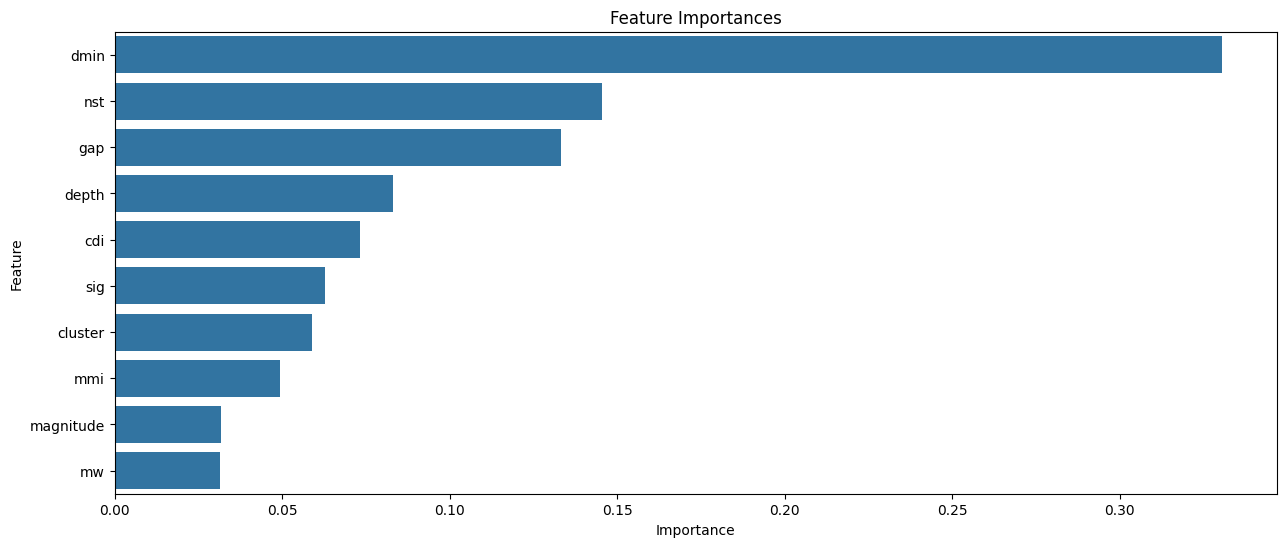

In [108]:
from sklearn.ensemble import RandomForestClassifier

# Prepare data
X = df_xyz.drop(['tsunami'], axis=1)  # Exclude target
y = df['tsunami']

# Handle categorical and missing values if required
X = pd.get_dummies(X, drop_first=True)

# Fit a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Feature Importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(15, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()


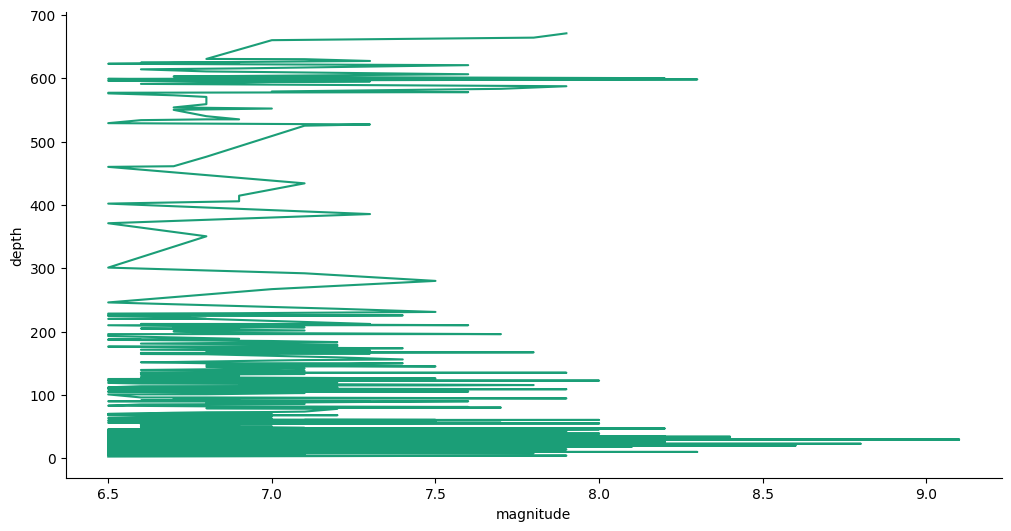

In [109]:
# earthquake_id vs magnitude

import matplotlib.pyplot as plt
import seaborn as sns

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['magnitude']
  ys = series['depth']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('depth', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('magnitude')
_ = plt.ylabel('depth')

# Classifying the region in high, medium and low risk zones

In [110]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import folium
from folium.plugins import HeatMap

def analyze_clusters(df):
    """
    Extract features from pre-clustered earthquake data while keeping individual points
    """
    # Calculate cluster-level features
    cluster_features = df.groupby('cluster').agg({
        'depth': ['median', 'mean', 'std'],
        'magnitude': ['median', 'mean', 'std', 'max']
    }).reset_index()

    # Flatten multi-level columns
    cluster_features.columns = ['cluster', 'median_depth', 'mean_depth', 'std_depth',
                              'median_magnitude', 'mean_magnitude', 'std_magnitude',
                              'max_magnitude']

    # Calculate frequency features
    five_years_ago = pd.to_datetime(df['date_time']).max() - pd.Timedelta(days=5*365)

    freq_features = []
    for cluster in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster]
        dates = pd.to_datetime(cluster_data['date_time'])

        freq_features.append({
            'cluster': cluster,
            'freq_5years': len(cluster_data[dates >= five_years_ago]),
            'freq_major_5years': len(cluster_data[(dates >= five_years_ago) &
                                                (cluster_data['magnitude'] > 6)])
        })

    freq_df = pd.DataFrame(freq_features)

    # Merge all features
    cluster_features = cluster_features.merge(freq_df, on='cluster')

    return cluster_features

def classify_risks(features_df):
    """
    Classify clusters into risk zones based on combined risk factors
    """
    # Calculate risk score
    features_df['risk_score'] = (
        features_df['median_magnitude'] *
        features_df['freq_5years'] *
        np.log1p(features_df['freq_major_5years'] + 1)
    )

    # Classify into risk zones
    features_df['risk_zone'] = pd.qcut(
        features_df['risk_score'],
        q=3,
        labels=['Low', 'Medium', 'High']
    )

    return features_df

def visualize_points(df, cluster_risks):
    """
    Create interactive map showing all individual points colored by their cluster's risk level
    """
    # Merge risk zones back to original data
    df_with_risks = df.merge(
        cluster_risks[['cluster', 'risk_zone', 'risk_score']],
        on='cluster'
    )

    # Create base map
    m = folium.Map(location=[0, 0], zoom_start=2)

    # Add different layers for each risk level
    colors = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}

    # Create feature groups for each risk level
    risk_layers = {
        risk: folium.FeatureGroup(name=f'{risk} Risk')
        for risk in colors.keys()
    }

    # Add points to appropriate layers
    for idx, row in df_with_risks.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=3 + row['magnitude']/2,  # Size based on magnitude
            color=colors[row['risk_zone']],
            fill=True,
            popup=f"""
                <b>Earthquake Details</b><br>
                Date: {row['date_time']}<br>
                Magnitude: {row['magnitude']:.1f}<br>
                Depth: {row['depth']:.1f}<br>
                Risk Zone: {row['risk_zone']}<br>
                Cluster: {row['cluster']}
            """,
            opacity=0.7,
            fill_opacity=0.5
        ).add_to(risk_layers[row['risk_zone']])

    # Add heatmap layer
    heat_data = df_with_risks[['latitude', 'longitude', 'magnitude']].values.tolist()
    HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(
        folium.FeatureGroup(name='Heatmap')
    )

    # Add all layers to map
    for layer in risk_layers.values():
        layer.add_to(m)

    # Add layer control
    folium.LayerControl().add_to(m)

    return m

def analyze_and_visualize(df):
    """
    Complete pipeline for analysis and visualization
    """
    # Extract cluster features
    cluster_features = analyze_clusters(df)

    # Classify risks
    cluster_features = classify_risks(cluster_features)

    # Create visualization
    risk_map = visualize_points(df, cluster_features)

    return risk_map, cluster_features

In [111]:
risk_map, cluster_features = analyze_and_visualize(df)

In [112]:
risk_map

In [113]:
print("\nCluster Risk Distribution:")
print(cluster_features['risk_zone'].value_counts())


Cluster Risk Distribution:
risk_zone
Medium    5
Low       4
High      4
Name: count, dtype: int64


# Training an XGBoost gradient classifer to predict laebls for Tsunami risks

In [114]:
# Use this to drop rows where 'cluster' is -1:
data.drop(data[data['cluster'] == -1].index, inplace=True)

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd


# Encode categorical variables if needed
le = LabelEncoder()
if 'magnitude_type' in df.columns:
    data['magnitude_type_encoded'] = le.fit_transform(data['magType'])
    data = data.drop('magType', axis=1)

# Separate features and target
X = data.drop(['tsunami'], axis=1)  # Exclude the target
y = data['tsunami']

# One-hot encode categorical features and standardize
X = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [116]:
X_scaled

array([[-1.73515341, -1.01168858,  0.88620914, ..., -0.33390168,
        -0.70764967,  0.99693408],
       [-1.73168702, -1.01168858, -0.04779003, ..., -0.33390168,
        -0.70764967,  0.99693408],
       [-1.72822064, -0.78420418,  0.7225717 , ..., -0.33390168,
        -0.70764967,  0.99693408],
       ...,
       [ 1.72083019, -0.10175096, -0.49140743, ..., -0.33390168,
        -0.70764967, -1.00307535],
       [ 1.72429657, -0.78420418, -0.47018534, ..., -0.33390168,
        -0.70764967, -1.00307535],
       [ 1.72776295,  0.35321785, -0.45502671, ..., -0.33390168,
        -0.70764967, -1.00307535]])

In [117]:
import pandas as pd

# Convert categorical columns into numeric using one-hot encoding or label encoding
from sklearn.preprocessing import LabelEncoder

# Columns to encode
categorical_columns = ['magType','cluster']  # Example categorical columns

# Apply Label Encoding or One-Hot Encoding
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])


In [118]:
#removing unecessary columns

data.drop(['earthquake_id','title', 'latitude', 'longitude','date_time','magnitude'],axis=1, inplace= True)

In [119]:
data

depth  Year  cdi  mmi  tsunami  sig      dmin    gap  nst  magType   mw  \
0    192.96  2023    7    4        0  657  7.177000   25.0  114        8  6.5   
1     69.73  2023    8    6        0  775  0.679000   40.0   92        8  6.5   
2    171.37  2023    7    5        0  899  1.634000   28.0   70        8  6.6   
3     32.57  2023    6    6        1  860  0.907000   36.0  173        8  7.2   
4     21.00  2023    0    5        1  820  0.879451  172.8   79        0  8.3   
..      ...   ...  ...  ...      ...  ...       ...    ...  ...      ...  ...   
995   11.00  1995    0    9        0  776  0.000000    0.0    0        6  7.1   
996   20.20  1995    0    4        0  912  0.000000    0.0    0        5  7.7   
997   11.20  1995    0    6        0  732  0.000000    0.0    0        5  6.9   
998   14.00  1995    0    9        0  670  0.000000    0.0    0        5  6.6   
999   16.00  1995    0    7        0  776  0.000000    0.0    0        5  7.1   

     cluster  
0          0  
1          1  
2          1  
3          0  
4          0  
..       ...  
995        0  
996        0  
997        0  
998        3  
999        0  

[977 rows x 12 columns]

In [120]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [121]:
X_train

array([[ 0.88543195,  0.12573345, -0.06090225, ...,  2.99489361,
        -0.70764967, -1.00307535],
       [-1.21172961, -1.01168858, -0.48337335, ..., -0.33390168,
        -0.70764967,  0.99693408],
       [-0.89628878, -0.78420418, -0.48534398, ..., -0.33390168,
        -0.70764967,  0.99693408],
       ...,
       [-0.91015431, -1.01168858, -0.50808193, ..., -0.33390168,
        -0.70764967,  0.99693408],
       [ 1.33259532, -0.32923536,  0.5173996 , ..., -0.33390168,
         1.41312863, -1.00307535],
       [-0.09208799, -1.01168858, -0.42470944, ...,  2.99489361,
        -0.70764967, -1.00307535]])

In [122]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_prob_xgb):.2f}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       132
           1       0.87      0.92      0.89        64

    accuracy                           0.93       196
   macro avg       0.91      0.93      0.92       196
weighted avg       0.93      0.93      0.93       196

AUC-ROC Score: 0.96


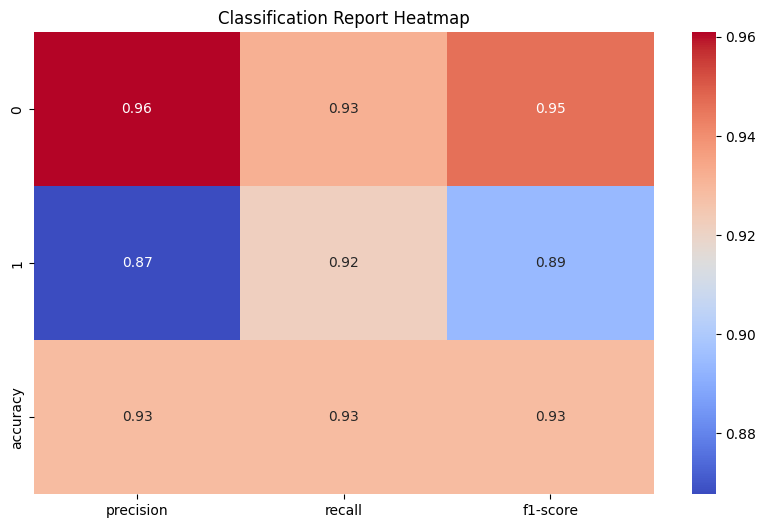

In [123]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

report_str = classification_report(y_test, y_pred_xgb, output_dict=True)
report_df = pd.DataFrame(report_str).transpose()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-2, :].drop(columns=['support']), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Classification Report Heatmap')
plt.show()

In [124]:
report_df

precision    recall  f1-score     support
0              0.960938  0.931818  0.946154  132.000000
1              0.867647  0.921875  0.893939   64.000000
accuracy       0.928571  0.928571  0.928571    0.928571
macro avg      0.914292  0.926847  0.920047  196.000000
weighted avg   0.930475  0.928571  0.929104  196.000000

In [125]:
# Prepare data for neural network
X = data.drop(['tsunami'], axis=1)
y = data['tsunami']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network model with improvements
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)), # Increased neurons
    keras.layers.Dropout(0.2), # Added dropout for regularization
    keras.layers.BatchNormalization(), # Added batch normalization
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2), # Added dropout
    keras.layers.BatchNormalization(), # Added batch normalization
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with improved optimizer and learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001) # Adjust learning rate as needed
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train the model with increased epochs and validation data and callbacks
model.fit(X_train_scaled, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# Further evaluation metrics
print(classification_report(y_test, y_pred))

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6969 - loss: 0.6220 - val_accuracy: 0.8734 - val_loss: 0.4953
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8701 - loss: 0.3926 - val_accuracy: 0.8734 - val_loss: 0.4486
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8335 - loss: 0.4276 - val_accuracy: 0.8734 - val_loss: 0.3946
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8603 - loss: 0.3588 - val_accuracy: 0.8734 - val_loss: 0.3596
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8738 - loss: 0.3483 - val_accuracy: 0.8734 - val_loss: 0.3222
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8699 - loss: 0.3187 - val_accuracy: 0.8734 - val_loss: 0.3026
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8767 - loss: 0.3065 - val_accuracy: 0.8734 - val_loss: 0.2999
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8648 - loss: 0.3031 - val_accuracy: 0.8734 - val_loss: 0.

In [130]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy}")


accuracy = accuracy_score(y_test, y_pred)
print(f"Neural Network Accuracy: {accuracy}")

XGBoost Accuracy: 0.9285714285714286
Neural Network Accuracy: 0.8826530612244898


# So in our case XGBoost is performing well than a Sequential ANN